# Prediction Model of the Energy Consumption in France - XGBoost Time Series Model

## Libraries

In [11]:
# pip install xgboost

     |████████████████████████████████| 1.8 MB 2.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [43]:
# Importing libraries :
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## Importing the data and fixing some data types

In [3]:
# Importing dataset :

df = pd.read_csv('/Users/adel/Desktop/Final-Project---IronHack-Paris/MySQL/MySQL Extract (Insights)/merged_dataset_final.csv')
df.head()

,Datetime,date,Year,Month,Day,Hour,Weekday,Consumption (MW),Fuel oil (MW),Coal (MW),...,CO2 emissions intensity (g/kWh),Trading with England (MW),Trading with Spain (MW),Trading with Italy (MW),Trading with Switzerland (MW),Trading with Germany-Belgium (MW),Flag Holiday,Average temperature (°C),Reference temperature (°C),Temperature Deviation (°C)
0,2012-01-01 00:00:00,2012-01-01,2012,1,1,0,6,58315,492,25,...,33,-1750,-1200,-862,-2625,-2940,1,11.7,4.6,7.1
1,2012-01-01 00:30:00,2012-01-01,2012,1,1,0,6,58315,492,25,...,33,-1750,-1200,-862,-2625,-2940,1,11.7,4.6,7.1
2,2012-01-01 01:00:00,2012-01-01,2012,1,1,1,6,56231,492,25,...,34,-1750,-1400,-862,-2625,-2714,1,11.7,4.6,7.1
3,2012-01-01 01:30:00,2012-01-01,2012,1,1,1,6,56075,491,25,...,35,-1750,-1400,-862,-2625,-2714,1,11.7,4.6,7.1
4,2012-01-01 02:00:00,2012-01-01,2012,1,1,2,6,55532,492,25,...,35,-1750,-1400,-862,-2327,-1088,1,11.7,4.6,7.1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182592 entries, 0 to 182591
Data columns (total 28 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Datetime                           182592 non-null  object 
 1   date                               182592 non-null  object 
 2   Year                               182592 non-null  int64  
 3   Month                              182592 non-null  int64  
 4   Day                                182592 non-null  int64  
 5   Hour                               182592 non-null  int64  
 6   Weekday                            182592 non-null  int64  
 7   Consumption (MW)                   182592 non-null  int64  
 8   Fuel oil (MW)                      182592 non-null  int64  
 9   Coal (MW)                          182592 non-null  int64  
 10  Gas (MW)                           182592 non-null  int64  
 11  Nuclear (MW)                       1825

In [5]:
# Converting datetime column to datetime and date column to date :

df['Datetime'] = pd.to_datetime(df['Datetime'])
df['date'] = pd.to_datetime(df['date'])

In [6]:
df.shape

(182592, 28)

In [7]:
# Checking the time range of the dataset :

print('The dataset starts from {} and ends at {}'.format(df['Datetime'].min(), df['Datetime'].max()))

The dataset starts from 2012-01-01 00:00:00 and ends at 2022-05-31 23:30:00


In [8]:
# Putting datetime as index :

df = df.set_index('Datetime')
df.head()

,date,Year,Month,Day,Hour,Weekday,Consumption (MW),Fuel oil (MW),Coal (MW),Gas (MW),...,CO2 emissions intensity (g/kWh),Trading with England (MW),Trading with Spain (MW),Trading with Italy (MW),Trading with Switzerland (MW),Trading with Germany-Belgium (MW),Flag Holiday,Average temperature (°C),Reference temperature (°C),Temperature Deviation (°C)
Datetime,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,2012-01-01,2012,1,1,0,6,58315,492,25,3816,...,33,-1750,-1200,-862,-2625,-2940,1,11.7,4.6,7.1
2012-01-01 00:30:00,2012-01-01,2012,1,1,0,6,58315,492,25,3816,...,33,-1750,-1200,-862,-2625,-2940,1,11.7,4.6,7.1
2012-01-01 01:00:00,2012-01-01,2012,1,1,1,6,56231,492,25,3834,...,34,-1750,-1400,-862,-2625,-2714,1,11.7,4.6,7.1
2012-01-01 01:30:00,2012-01-01,2012,1,1,1,6,56075,491,25,3832,...,35,-1750,-1400,-862,-2625,-2714,1,11.7,4.6,7.1
2012-01-01 02:00:00,2012-01-01,2012,1,1,2,6,55532,492,25,3839,...,35,-1750,-1400,-862,-2327,-1088,1,11.7,4.6,7.1


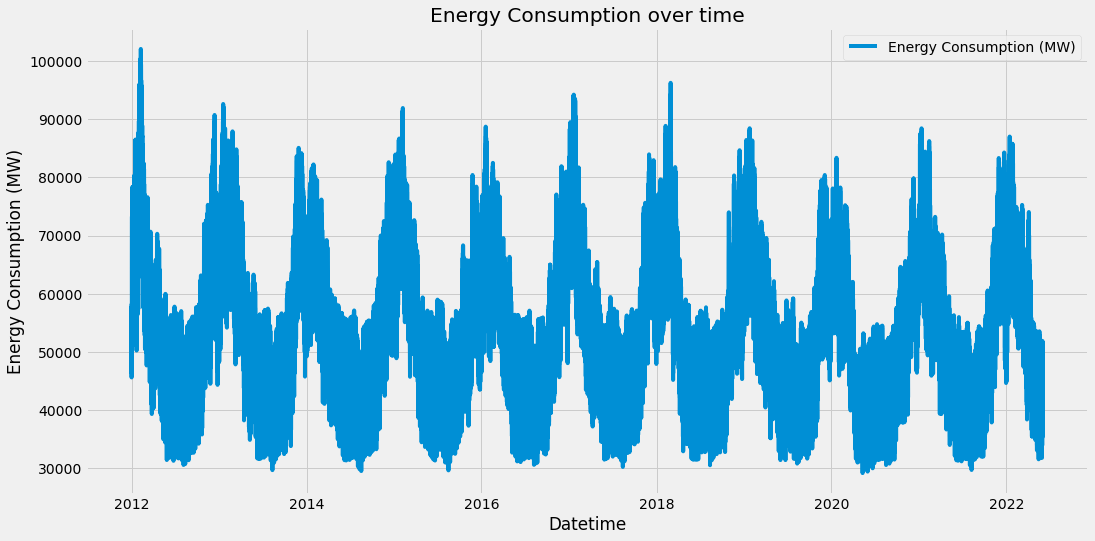

In [9]:
# Plotting the energy consumption over datetime :

plt.figure(figsize=(16,8))
plt.plot(df['Consumption (MW)'], label='Energy Consumption (MW)')
plt.title('Energy Consumption over time')
plt.xlabel('Datetime')
plt.ylabel('Energy Consumption (MW)')
plt.legend(loc='best')
plt.show()

We can see that there is an seasonal pattern.

## Checking Outliers

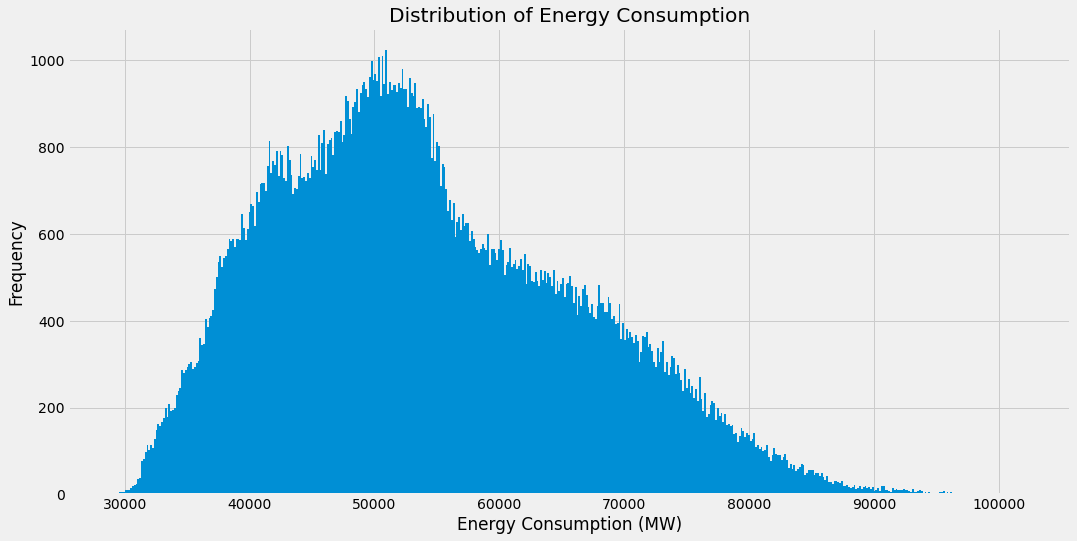

In [10]:
# Plotting in histgram the distribution of the energy consumption :

plt.figure(figsize=(16,8))
plt.hist(df['Consumption (MW)'], bins=500)
plt.title('Distribution of Energy Consumption')
plt.xlabel('Energy Consumption (MW)')
plt.ylabel('Frequency')
plt.show()

In [11]:
# Checking the outliers values, the very low values :

df[df['Consumption (MW)'] < 30000].head()

,date,Year,Month,Day,Hour,Weekday,Consumption (MW),Fuel oil (MW),Coal (MW),Gas (MW),...,CO2 emissions intensity (g/kWh),Trading with England (MW),Trading with Spain (MW),Trading with Italy (MW),Trading with Switzerland (MW),Trading with Germany-Belgium (MW),Flag Holiday,Average temperature (°C),Reference temperature (°C),Temperature Deviation (°C)
Datetime,,,,,,,,,,,,,,,,,,,,,
2013-08-11 07:00:00,2013-08-11,2013,8,11,7,6,29632,311,-26,663,...,30,-1571,-1200,-353,-2966,-3453,0,19.8,20.7,-0.9
2014-08-10 07:00:00,2014-08-10,2014,8,10,7,6,29782,216,-25,511,...,28,-1611,-1100,-747,-3000,-3169,0,20.9,20.8,0.1
2014-08-17 05:30:00,2014-08-17,2014,8,17,5,6,29938,215,-12,577,...,33,-1275,-1200,-747,-791,-405,0,17.0,20.3,-3.3
2014-08-17 07:00:00,2014-08-17,2014,8,17,7,6,29477,215,-14,571,...,33,-1275,-1200,0,-480,-1155,0,17.0,20.3,-3.3
2014-08-17 07:30:00,2014-08-17,2014,8,17,7,6,29884,216,-14,575,...,33,-1275,-1200,0,-480,-1155,0,17.0,20.3,-3.3


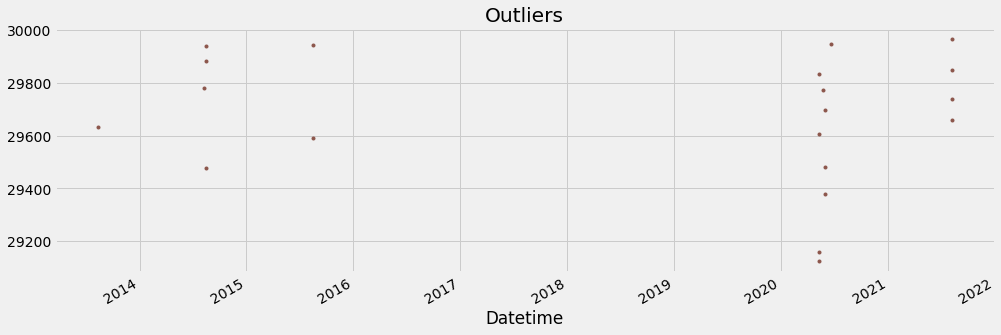

In [12]:
# Let's plot the energy consumption for the outliers values :

df[df['Consumption (MW)'] < 30000]['Consumption (MW)'].plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [13]:
# Checking the outliers values, the high low values :

df[df['Consumption (MW)'] > 100000].head()

,date,Year,Month,Day,Hour,Weekday,Consumption (MW),Fuel oil (MW),Coal (MW),Gas (MW),...,CO2 emissions intensity (g/kWh),Trading with England (MW),Trading with Spain (MW),Trading with Italy (MW),Trading with Switzerland (MW),Trading with Germany-Belgium (MW),Flag Holiday,Average temperature (°C),Reference temperature (°C),Temperature Deviation (°C)
Datetime,,,,,,,,,,,,,,,,,,,,,
2012-02-07 19:00:00,2012-02-07,2012,2,7,19,1,100430,5361,4768,7636,...,129,1804,1000,667,-298,3766,0,-4.8,5.9,-10.7
2012-02-07 19:30:00,2012-02-07,2012,2,7,19,1,100005,5330,4609,7611,...,127,1804,1000,667,-298,3766,0,-4.8,5.9,-10.7
2012-02-08 10:00:00,2012-02-08,2012,2,8,10,2,100014,5433,5185,7787,...,135,2000,500,321,27,4399,0,-4.9,6.0,-10.9
2012-02-08 19:00:00,2012-02-08,2012,2,8,19,2,102098,5477,5201,7994,...,134,2000,1000,840,68,4352,0,-4.9,6.0,-10.9
2012-02-08 19:30:00,2012-02-08,2012,2,8,19,2,101201,5483,5158,7983,...,135,2000,1000,840,68,4352,0,-4.9,6.0,-10.9


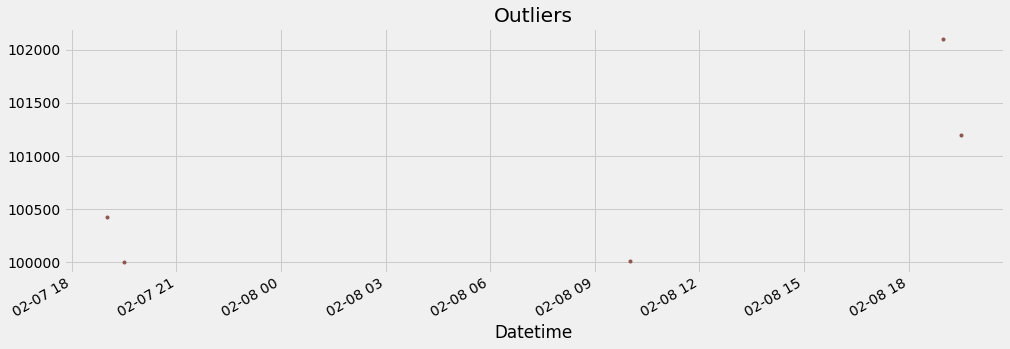

In [14]:
df[df['Consumption (MW)'] > 100000]['Consumption (MW)'].plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

## Time Series Cross Validation

In [15]:
# Importing library for time series split :
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24) # 1 year gap between train and test set for each split.
df = df.sort_index()

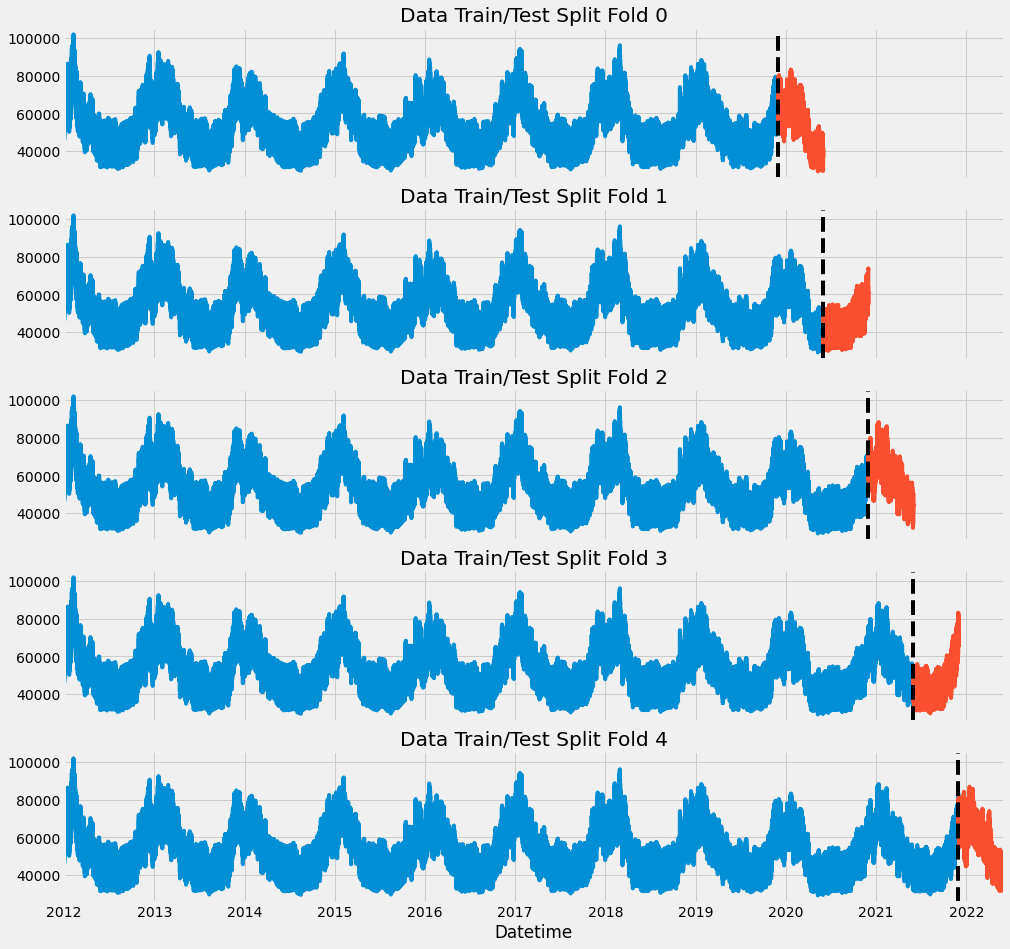

In [16]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Consumption (MW)'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Consumption (MW)'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## Feature Creation

In [17]:
# Creating new features from datetime in order to use them in the model :

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.weekofyear
    return df

df = create_features(df)

## Vizualize the New Features and the Target Variable

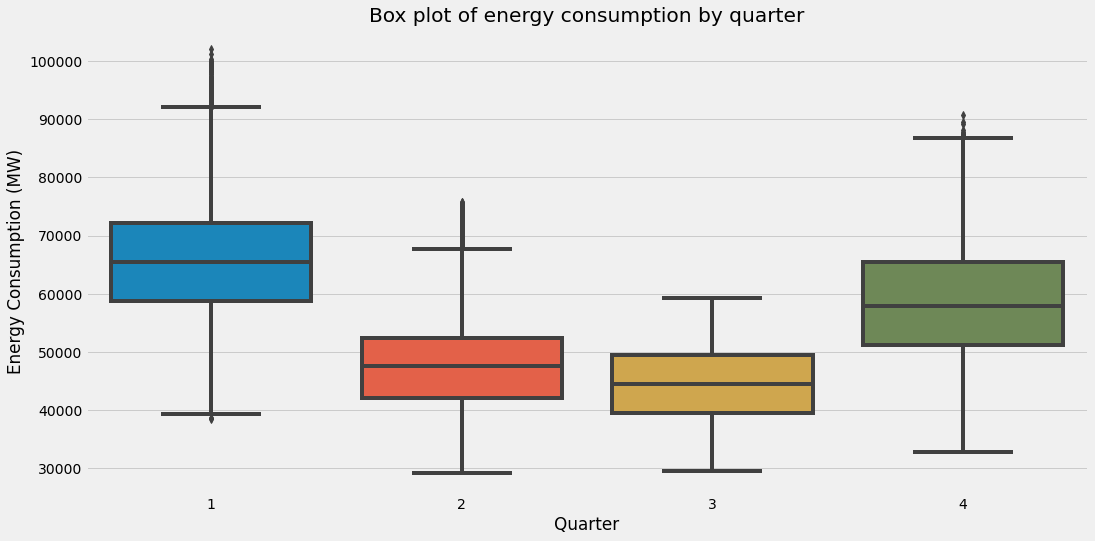

In [18]:
# Box plot of energy consumption by quarter :
plt.figure(figsize=(16,8))
sns.boxplot(x='quarter', y='Consumption (MW)', data=df)
plt.title('Box plot of energy consumption by quarter')
plt.xlabel('Quarter')
plt.ylabel('Energy Consumption (MW)')
plt.show()

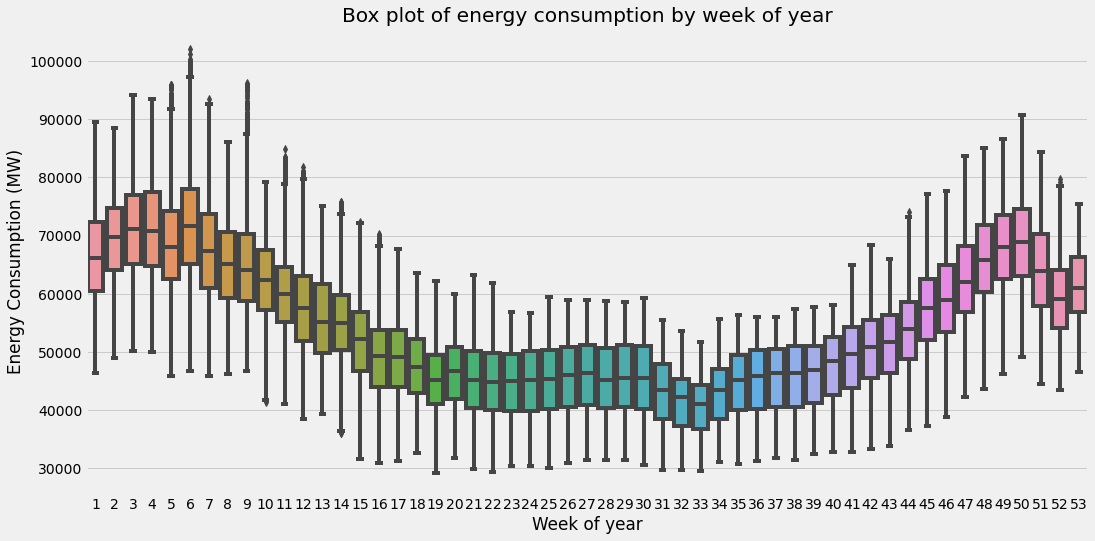

In [19]:
# Box plot of energy consumption by week of year :
plt.figure(figsize=(16,8))
sns.boxplot(x='weekofyear', y='Consumption (MW)', data=df)
plt.title('Box plot of energy consumption by week of year')
plt.xlabel('Week of year')
plt.ylabel('Energy Consumption (MW)')
plt.show()

## Lag Features

In [20]:
# We are going to modify the dataset in order to use it in the model but we are going to keep the original dataset :
df_XGBoost = df.copy()
df_XGBoost.head()

,date,Year,Month,Day,Hour,Weekday,Consumption (MW),Fuel oil (MW),Coal (MW),Gas (MW),...,Trading with Italy (MW),Trading with Switzerland (MW),Trading with Germany-Belgium (MW),Flag Holiday,Average temperature (°C),Reference temperature (°C),Temperature Deviation (°C),quarter,dayofyear,weekofyear
Datetime,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,2012-01-01,2012,1,1,0,6,58315,492,25,3816,...,-862,-2625,-2940,1,11.7,4.6,7.1,1,1,52
2012-01-01 00:30:00,2012-01-01,2012,1,1,0,6,58315,492,25,3816,...,-862,-2625,-2940,1,11.7,4.6,7.1,1,1,52
2012-01-01 01:00:00,2012-01-01,2012,1,1,1,6,56231,492,25,3834,...,-862,-2625,-2714,1,11.7,4.6,7.1,1,1,52
2012-01-01 01:30:00,2012-01-01,2012,1,1,1,6,56075,491,25,3832,...,-862,-2625,-2714,1,11.7,4.6,7.1,1,1,52
2012-01-01 02:00:00,2012-01-01,2012,1,1,2,6,55532,492,25,3839,...,-862,-2327,-1088,1,11.7,4.6,7.1,1,1,52


In [21]:
# Creating a function to add lags :
def add_lags(df_XGBoost):
    target_map = df_XGBoost['Consumption (MW)'].to_dict()
    df_XGBoost['lag1'] = (df_XGBoost.index - pd.Timedelta('364 days')).map(target_map)
    df_XGBoost['lag2'] = (df_XGBoost.index - pd.Timedelta('728 days')).map(target_map)
    df_XGBoost['lag3'] = (df_XGBoost.index - pd.Timedelta('1092 days')).map(target_map)
    return df_XGBoost

# Thes lags are the energy consumption of the same day of the Y-1, Y-2 and Y-3. It is useful to predict the energy consumption of the next day.
# Usely, the energy consumption of the next day is similar to the energy consumption of the same day of the previous year.

In [22]:
# Adding lags : 
df_XGBoost = add_lags(df_XGBoost)

In [23]:
# Checking the new dataset :
df_XGBoost.tail()

,date,Year,Month,Day,Hour,Weekday,Consumption (MW),Fuel oil (MW),Coal (MW),Gas (MW),...,Flag Holiday,Average temperature (°C),Reference temperature (°C),Temperature Deviation (°C),quarter,dayofyear,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-05-31 21:30:00,2022-05-31,2022,5,31,21,1,44043,83,454,4025,...,0,16.7,17.4,-0.7,2,151,22,43659.0,42167.0,44606.0
2022-05-31 22:00:00,2022-05-31,2022,5,31,22,1,44019,82,274,3908,...,0,16.7,17.4,-0.7,2,151,22,43570.0,42337.0,44749.0
2022-05-31 22:30:00,2022-05-31,2022,5,31,22,1,45067,83,192,3879,...,0,16.7,17.4,-0.7,2,151,22,44515.0,43545.0,45823.0
2022-05-31 23:00:00,2022-05-31,2022,5,31,23,1,46703,81,3,3933,...,0,16.7,17.4,-0.7,2,151,22,46444.0,45958.0,48011.0
2022-05-31 23:30:00,2022-05-31,2022,5,31,23,1,45279,82,2,3748,...,0,16.7,17.4,-0.7,2,151,22,45579.0,45418.0,47209.0


## Training Using Cross Validation

In [26]:
# Inside the loop
fold = 0
preds = []
scores = []
mae_scores = []
mape_scores = []
for train_idx, val_idx in tss.split(df_XGBoost):
    train = df_XGBoost.iloc[train_idx]
    test = df_XGBoost.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['Year', 'Month', 'Day', 'Hour', 'Weekday','Flag Holiday', 'Average temperature (°C)',
        'Reference temperature (°C)', 'Temperature Deviation (°C)', 'quarter', 'dayofyear', 'weekofyear', 'lag1','lag2','lag3']
    TARGET = 'Consumption (MW)'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', # gbtree is the default and base score is the initial prediction score of all instances, common value is 0.5   
                           n_estimators=1000, # 1000 trees
                           early_stopping_rounds=50, # stop if 50 consequent rounds without improvement because of overfitting
                           objective='reg:linear',
                           max_depth=3, # maximum depth of a tree
                           learning_rate=0.01) # learning rate is the step size shrinkage used to prevent overfitting
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)], # evaluation set to watch performance on train and test set during training
            verbose=100) # verbose is the number of trees you want to display

    y_pred = reg.predict(X_test) # making predictions on the test set
    preds.append(y_pred) # appending the predictions to the list preds
    score = np.sqrt(mean_squared_error(y_test, y_pred)) # calculating the RMSE score of the model on the test set
    scores.append(score) # appending the score to the list scores

    # Calculate and print Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"MAE for Fold {fold}: {mae}")

    # Calculate and print Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print(f"MAPE for Fold {fold}: {mape:.2f}%")

    # Append the MAE and MAPE scores to their respective lists
    mae_scores.append(mae)
    mape_scores.append(mape)

    fold += 1



[23:11:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:55159.59886	validation_1-rmse:55679.09648
[100]	validation_0-rmse:20646.10565	validation_1-rmse:18953.11156
[200]	validation_0-rmse:8320.63037	validation_1-rmse:6754.47741
[300]	validation_0-rmse:4309.54193	validation_1-rmse:4775.54010
[343]	validation_0-rmse:3657.89718	validation_1-rmse:4903.48225
MAE for Fold 0: 3899.9452032498575
MAPE for Fold 0: 7.59%
[23:11:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:55195.41407	validation_1-rmse:46617.79025
[100]	validation_0-rmse:20684.28190	validation_1-rmse:16488.21046
[200]	validation_0-rmse:8390.72052	validation_1-rmse:6301.08

In [28]:
# Printing the RMSE, MAE and MAPE score of the model on each fold :
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')
print(f'MAE across folds {np.mean(mae_scores):0.4f}')
print(f'Fold mae_scores:{mae_scores}')
print(f'MAPE across folds {np.mean(mape_scores):0.4f}')
print(f'Fold mape_scores:{mape_scores}')

Score across folds 3584.5040
Fold scores:[4770.3555959787045, 3921.8128080877173, 4432.488417990235, 1788.0898215403438, 3009.773272768268]
MAE across folds 2901.6254
Fold mae_scores:[3899.9452032498575, 3356.491919725671, 3552.1659309003994, 1352.1238872092608, 2347.39983010488]
MAPE across folds 5.5710
Fold mape_scores:[7.5888100886724885, 7.129932493506132, 6.278940209492066, 2.8368958216252302, 4.020402806358494]


The results look good. The RMSE score on the validation set is decreasing as the number of trees increases, indicating that the model is learning and improving. The early stopping parameter is set to stop the training if the validation score has not improved after 50 rounds, which is a good technique to prevent overfitting.

Also, there doesn't seem to be any significant difference between the RMSE score on the training set and the validation set, which is another indication that the model is not overfitting.

However, it's always good to perform additional tests to confirm the accuracy and stability of your model.

Based on the results provided, the XGBoost time series model with cross-validation achieved an overall score across folds of 3584.5040. The cross-validation approach is a good way to validate the performance of the model on different subsets of the data.

The model's performance was evaluated using three different metrics: Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), and the overall score. The MAE measures the average absolute difference between the predicted and actual values, while the MAPE measures the average percentage difference between the predicted and actual values.

The MAE across the folds was 2901.6254, which means that on average, the model's predictions were off by about 2901.6254 units. The MAPE across the folds was 5.5710, which indicates that the average percentage difference between the predicted and actual values was 5.5710%.

Looking at the individual fold scores, we can see that the model's performance varied across the different subsets of the data. The highest fold score was 4770.3556, and the lowest was 1788.0898. Similarly, the MAE and MAPE scores also varied across the folds.

Overall, the results suggest that the XGBoost time series model with cross-validation is reasonably effective in predicting energy consumption in France. However, there is some variation in performance across different subsets of the data, which could indicate the need for further optimization or refinement of the model.

### Retraining on all data

In [29]:
FEATURES = ['Year', 'Month', 'Day', 'Hour', 'Weekday','Flag Holiday', 'Average temperature (°C)',
        'Reference temperature (°C)', 'Temperature Deviation (°C)', 'quarter', 'dayofyear', 'weekofyear', 'lag1','lag2','lag3']
TARGET = 'Consumption (MW)'

X_all = df_XGBoost[FEATURES]
y_all = df_XGBoost[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                        n_estimators=500, # 500 trees because we don't need to overfit the model on the whole dataset and we've seen before that 500 trees is enough
                            early_stopping_rounds=50,
                            objective='reg:linear', # regression task because we are predicting a numeric variable
                            max_depth=3, # maximum depth of a tree
                            learning_rate=0.01) # learning rate is the step size shrinkage used to prevent overfitting
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[23:17:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:54880.61149
[100]	validation_0-rmse:20558.83432
[200]	validation_0-rmse:8326.41601
[300]	validation_0-rmse:4389.55048
[400]	validation_0-rmse:3331.56074
[499]	validation_0-rmse:3023.45069


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [47]:
# predict on the validation set
y_pred = reg.predict(X_all)

# compute evaluation metrics
rmse = np.sqrt(mean_squared_error(y_all, y_pred))
mae = mean_absolute_error(y_all, y_pred)
mape = np.mean(np.abs((y_all - y_pred) / y_all)) * 100
r2 = r2_score(y_all, y_pred)

# print the evaluation metrics
print("Root Mean Squared Error: {:.2f}".format(rmse))
print("Mean Absolute Error: {:.2f}".format(mae))
print("Mean Absolute Percentage Error: {:.2f}%".format(mape))
print('R-squared: {:.3f}'.format(r2))

Root Mean Squared Error: 3023.45
Mean Absolute Error: 2259.36
Mean Absolute Percentage Error: 4.18%
R-squared: 0.937


    Root Mean Squared Error: 3023.45
RMSE measures the standard deviation of the residuals, which are the differences between the predicted and actual values. The lower the RMSE, the better the model's performance in predicting the outcome variable. The RMSE value of 3023.45 MW indicates that, on average, the XGBoost model's predictions are off by around 3023 MW, which is relatively low for energy consumption prediction.

    Mean Absolute Error: 2259.36
MAE measures the average magnitude of the errors in the predicted values, without considering the direction of the errors. A lower MAE indicates better performance of the model. The MAE value of 2259.36 MW suggests that, on average, the XGBoost model's predictions are off by around 2259 MW, which is a relatively small error for energy consumption prediction.

    Mean Absolute Percentage Error: 4.18%
MAPE measures the average percentage difference between the predicted and actual values, normalized by the actual value. A lower MAPE indicates better performance of the model. The MAPE value of 4.18% indicates that, on average, the XGBoost model's predictions are off by around 4.18% of the actual energy consumption values, which is a relatively small percentage error.

    R-squared: 0.937
 R-squared measures the proportion of the variance in the outcome variable that can be explained by the predictors in the model. A higher R-squared indicates better performance of the model in explaining the variability in the outcome variable. The high R-squared value of 0.937 suggests that the XGBoost model explains a large portion of the variance in the energy consumption data and has a good fit.

## Comparing with Prophet Metrics

Prophet Metrics :

    Root Mean Squared Error (RMSE): 5064.35 MW
    Mean Absolute Error (MAE): 3814.31 MW
    Mean Absolute Percentage Error (MAPE): 730.67%
    R-squared: 0.812

The XGBoost model appears to perform better than the Prophet model based on the evaluation metrics. The lower RMSE and MAE values indicate that the XGBoost model has smaller prediction errors compared to the Prophet model. Additionally, the lower MAPE value indicates that the XGBoost model has a better fit and is more accurate in predicting energy consumption. The high R-squared value of 0.937 suggests that the XGBoost model explains a large portion of the variance in the data and has a good fit. Overall, the XGBoost model seems to be a more effective model for predicting energy consumption in this project compared to the Prophet model.

#### Features importance

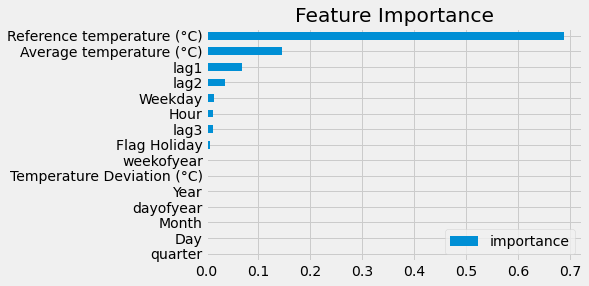

In [31]:
# Let's check the feature importance :
fi = pd.DataFrame(data=reg.feature_importances_,
                index=reg.feature_names_in_,    
                columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.legend(loc='lower right')
plt.show()

Interpreting the feature importance :
The most important feature is the Reference temperature (°C) with a feature importance of 0.7. It means that the model uses the reference temperature to split the data across all trees. 0.7 is the number of times the reference temperature is used to split the data across all trees.

## Predict the Future

In [32]:
df_XGBoost.index.max()

Timestamp('2022-05-31 23:30:00')

In [33]:
# Create future dataframe
future = pd.date_range('2022-06-01','2023-06-02', freq='30min') # 1 year of data with 30 minutes frequency
future_df = pd.DataFrame(index=future) # create a dataframe with the future dates
future_df['isFuture'] = True # add a column to indicate that the data is from the future 
df_XGBoost['isFuture'] = False # add a column to indicate that the data is from the past
df_and_future = pd.concat([df_XGBoost, future_df]) # concatenate the past and future dataframes
df_and_future = create_features(df_and_future) # create features for the future dataframe
df_and_future = add_lags(df_and_future) # add lags to the future dataframe to predict the energy consumption of the next day

In [34]:
df_and_future.columns

Index(['date', 'Year', 'Month', 'Day', 'Hour', 'Weekday', 'Consumption (MW)',
       'Fuel oil (MW)', 'Coal (MW)', 'Gas (MW)', 'Nuclear (MW)', 'Wind (MW)',
       'Solar (MW)', 'Hydroelectric (MW)', 'Pumped storage (MW)',
       'Bioenergy (MW)', 'Physical exchanges (MW)',
       'CO2 emissions intensity (g/kWh)', 'Trading with England (MW)',
       'Trading with Spain (MW)', 'Trading with Italy (MW)',
       'Trading with Switzerland (MW)', 'Trading with Germany-Belgium (MW)',
       'Flag Holiday', 'Average temperature (°C)',
       'Reference temperature (°C)', 'Temperature Deviation (°C)', 'quarter',
       'dayofyear', 'weekofyear', 'lag1', 'lag2', 'lag3', 'isFuture'],
      dtype='object')

In [35]:
df_and_future.tail()

,date,Year,Month,Day,Hour,Weekday,Consumption (MW),Fuel oil (MW),Coal (MW),Gas (MW),...,Average temperature (°C),Reference temperature (°C),Temperature Deviation (°C),quarter,dayofyear,weekofyear,lag1,lag2,lag3,isFuture
2023-06-01 22:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2,152,22,NaN,43928.0,42066.0,True
2023-06-01 22:30:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2,152,22,NaN,45018.0,43112.0,True
2023-06-01 23:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2,152,22,NaN,46731.0,45316.0,True
2023-06-01 23:30:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2,152,22,NaN,45798.0,44909.0,True
2023-06-02 00:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2,153,22,NaN,45236.0,44324.0,True


In [36]:
future_w_features = df_and_future.query('isFuture').copy() # creating a dataframe with the future dates

In [37]:
future_w_features.tail()

,date,Year,Month,Day,Hour,Weekday,Consumption (MW),Fuel oil (MW),Coal (MW),Gas (MW),...,Average temperature (°C),Reference temperature (°C),Temperature Deviation (°C),quarter,dayofyear,weekofyear,lag1,lag2,lag3,isFuture
2023-06-01 22:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2,152,22,NaN,43928.0,42066.0,True
2023-06-01 22:30:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2,152,22,NaN,45018.0,43112.0,True
2023-06-01 23:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2,152,22,NaN,46731.0,45316.0,True
2023-06-01 23:30:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2,152,22,NaN,45798.0,44909.0,True
2023-06-02 00:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2,153,22,NaN,45236.0,44324.0,True


In [38]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

In [39]:
future_w_features.tail()

,date,Year,Month,Day,Hour,Weekday,Consumption (MW),Fuel oil (MW),Coal (MW),Gas (MW),...,Reference temperature (°C),Temperature Deviation (°C),quarter,dayofyear,weekofyear,lag1,lag2,lag3,isFuture,pred
2023-06-01 22:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2,152,22,NaN,43928.0,42066.0,True,77074.890625
2023-06-01 22:30:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2,152,22,NaN,45018.0,43112.0,True,77074.890625
2023-06-01 23:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2,152,22,NaN,46731.0,45316.0,True,77249.320312
2023-06-01 23:30:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2,152,22,NaN,45798.0,44909.0,True,77219.523438
2023-06-02 00:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2,153,22,NaN,45236.0,44324.0,True,77177.312500


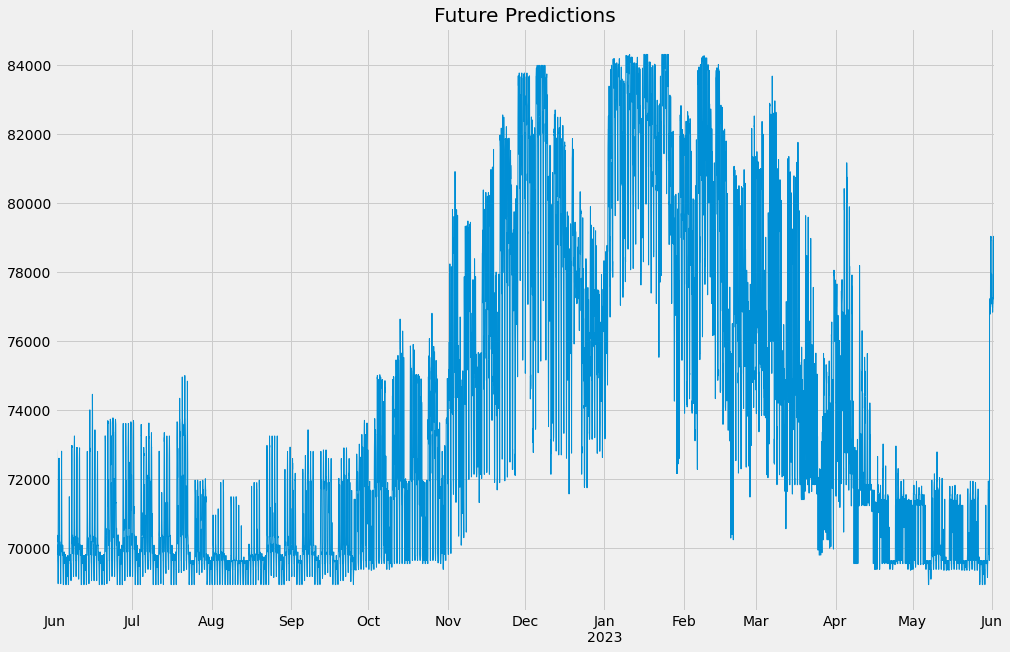

In [40]:
# Plotting the predictions :
future_w_features['pred'].plot(figsize=(15, 10),
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

## Saving the model

In [272]:
# Saving the model :
import pickle
pickle.dump(reg, open('model_XGBoost.pkl', 'wb'))

# Loading the model :
model_XGBoost = pickle.load(open('model_XGBoost.pkl', 'rb'))

# Checking the model :
model_XGBoost.predict(future_w_features[FEATURES])

array([69843.79, 69744.66, 69642.24, ..., 77249.32, 77219.52, 77177.31],
      dtype=float32)

# END OF XGBOOST MODEL
## GO TO PROPHET NOTEBOOK TO CHECK THE OTHER MODEL & THE COMPARAISON BETWEEN THE MODELS